In [1]:
!pip install torchsummary 

In [2]:
import time
import inspect
import numpy as np
import pandas as pd
from random import randint

import torch
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


 # 1. Import MNIST Data

## 1.1 Import MNIST Data from Pytorch

In [3]:
def get_data_loaders(train_batch_size, test_batch_size):
    
    data_transform = Compose([Resize((224, 224)),ToTensor(), Normalize((0.1307,), (0.3081,))])

    mnist_train = MNIST(root=".", train=True, download=True, transform=data_transform)
    mnist_test = MNIST(root=".", train=False, download=True, transform=data_transform)

    train_idx = (mnist_train.train_labels == 0) | (mnist_train.train_labels == 1)
    mnist_train.data = mnist_train.data[train_idx]
    mnist_train.targets = mnist_train.targets[train_idx]

    test_idx = (mnist_test.test_labels == 0) | (mnist_test.test_labels == 1)
    mnist_test.data = mnist_test.data[test_idx]
    mnist_test.targets = mnist_test.targets[test_idx]

    train_loader = DataLoader(mnist_train, batch_size = train_batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size = test_batch_size, shuffle=False)

    return train_loader, test_loader

In [4]:
train_batch_size = 256
test_batch_size = 256

train_loader, test_loader = get_data_loaders(train_batch_size, test_batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([256, 1, 224, 224])

## 1.2 Display the train_loader dataset image

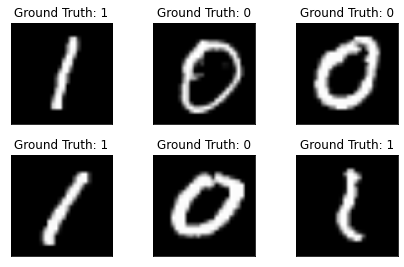

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# 2. Pretrain Feature Extrator Module

## 1.1 Define ResNet model

In [7]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=2)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [8]:
from torchsummary import summary

model = MnistResNet()
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 1.2 Metric and Print Score Function

In [9]:
def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    # just an utility printing function
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

## 1.3 Training 

In [10]:
start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 5
train_loader, test_loader = get_data_loaders(train_batch_size, test_batch_size)
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = optim.Adadelta(model.parameters())


losses = []
batches = len(train_loader)
test_batches = len(test_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        # training step for single batch
        model.zero_grad() # to make sure that all the grads are 0 
        """
        model.zero_grad() and optimizer.zero_grad() are the same 
        IF all your model parameters are in that optimizer. 
        I found it is safer to call model.zero_grad() to make sure all grads are zero, 
        e.g. if you have two or more optimizers for one model.

        """
        outputs = model(X) # forward
        loss = loss_function(outputs, y) # get loss
        loss.backward() # accumulates the gradient (by addition) for each parameter.
        optimizer.step() # performs a parameter update based on the current gradient 

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # ----------------- VALIDATION  ----------------- 
    test_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            test_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
          
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {test_losses/test_batches}")
    print_scores(precision, recall, f1, accuracy, test_batches)
    losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5, training loss: 0.3303018194437027, validation loss: 0.3219810724258423
	     precision: 1.0000
	        recall: 0.9855
	            F1: 0.9927
	      accuracy: 0.9922


Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5, training loss: 0.31584530651569365, validation loss: 0.3162458837032318
	     precision: 1.0000
	        recall: 0.9945
	            F1: 0.9972
	      accuracy: 0.9970


Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5, training loss: 0.31477747321128846, validation loss: 0.313934326171875
	     precision: 1.0000
	        recall: 0.9992
	            F1: 0.9996
	      accuracy: 0.9996


Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5, training loss: 0.31417147040367127, validation loss: 0.3140283524990082
	     precision: 1.0000
	        recall: 0.9992
	            F1: 0.9996
	      accuracy: 0.9996


Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5, training loss: 0.3138246017694473, validation loss: 0.3136637806892395
	     precision: 1.0000
	        recall: 1.0000
	            F1: 1.0000
	      accuracy: 1.0000
Training time: 9858.823473215103s


## 1.4 Save ResNet model 

In [11]:
torch.save(model.state_dict(), 'mnist_state.pt')

# Bag Size Concept 
Condition : Each bag consists of 100 images with a fraction x of digit 0 and 1-x of digit 7.

In [12]:
x = randint(0, 100)
fraction = [x, (100-x)]
no_0 = np.repeat(0, fraction[0])
no_7 = np.repeat(7,fraction[1])
len_bags = np.append(no_0,no_7)